# Import Libraries

In [3]:
!pip install tldextract

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import math
from wordcloud import WordCloud
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse
import tldextract
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from joblib import Parallel, delayed
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
import pickle


plt.style.use('ggplot')
pd.set_option('display.max_columns', False)

In [138]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Import Dataset

https://drive.google.com/file/d/1CpMHkZ_E2Seh457UaeNfS6Yg24eXXeXq/view?usp=sharing

Test CSV always got indicated as a virus by google drive so must be inputted manually during session

In [5]:
train_df = pd.read_csv('https://drive.google.com/uc?id=1s8-JMNo7PwJebcWAcSMjJTzT8eUa9r7c')
test_df = pd.read_csv('/content/test.csv')

# Splitting Training and Validation Dataset

In [6]:
train_data, val_data = train_test_split(train_df)

# Exploratory Data Analysis

## Data Understanding

In [ ]:
print("Number of Training Data : ",len(train_data))

Number of Training Data :  105303


In [ ]:
print("Data types of each feature : ", train_data.dtypes)

Data types of each feature :  id                              int64
FILENAME                       object
URL                            object
URLLength                     float64
Domain                         object
DomainLength                  float64
IsDomainIP                    float64
TLD                            object
CharContinuationRate          float64
TLDLegitimateProb             float64
URLCharProb                   float64
TLDLength                     float64
NoOfSubDomain                 float64
HasObfuscation                float64
NoOfObfuscatedChar            float64
ObfuscationRatio              float64
NoOfLettersInURL              float64
LetterRatioInURL              float64
NoOfDegitsInURL               float64
DegitRatioInURL               float64
NoOfEqualsInURL               float64
NoOfQMarkInURL                float64
NoOfAmpersandInURL            float64
NoOfOtherSpecialCharsInURL    float64
SpacialCharRatioInURL         float64
IsHTTPS             

In [ ]:
numeric_columns = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()

In [ ]:
for column in numeric_columns:
    unique_threshold  = 5
    if train_data[column].nunique() < unique_threshold:
      categorical_columns.append(column)
      numeric_columns.remove(column)

In [ ]:
print("Banyak data numeric ",len(numeric_columns))
print("Banyak data categorical ",len(categorical_columns))

Banyak data numeric  37
Banyak data categorical  19


#### **Insight :**
* Kolom yang ada pada data sangat banyak, yaitu berjumlah 56 kolom atau fitur
* Berdasarkan nama kolom, banyak kolom yang sebenarnya tidak diperlukan dan bisa dihapus pada saat pemrosesan data
* Pada informasi data numeric ditemukan bahwa banyak data yang memiliki range yang sangat besar
* Range yang sangat besar bisa merupakan akibat sebuah outliers pada data

## Missing Data

In [ ]:
def feat_null_pct(data):
    missing = data.isnull().sum()
    nans = missing[missing > 0].sort_values(ascending=False)
    for col in nans.index:
        print(f"{col} Null Values: {round(100 - data[col].value_counts().sum()/len(data) * 100, 2)}% of the dataset ({len(data) - data[col].value_counts().sum()})")

In [ ]:
print("Missing Value on each feature : \n")
feat_null_pct(train_data)

Missing Value on each feature : 

Domain Null Values: 49.93% of the dataset (52580)
NoOfExternalRef Null Values: 49.49% of the dataset (52113)
LineOfCode Null Values: 49.32% of the dataset (51935)
HasSocialNet Null Values: 48.48% of the dataset (51050)
LargestLineLength Null Values: 48.32% of the dataset (50880)
NoOfCSS Null Values: 47.94% of the dataset (50480)
NoOfURLRedirect Null Values: 47.92% of the dataset (50456)
HasCopyrightInfo Null Values: 47.89% of the dataset (50429)
NoOfObfuscatedChar Null Values: 47.67% of the dataset (50200)
NoOfSelfRedirect Null Values: 47.49% of the dataset (50007)
HasPasswordField Null Values: 47.44% of the dataset (49952)
LetterRatioInURL Null Values: 46.77% of the dataset (49249)
HasObfuscation Null Values: 46.53% of the dataset (49001)
ObfuscationRatio Null Values: 45.97% of the dataset (48413)
NoOfLettersInURL Null Values: 45.1% of the dataset (47490)
SpacialCharRatioInURL Null Values: 44.76% of the dataset (47136)
NoOfEqualsInURL Null Values: 43.

In [ ]:
def feat_null_pct(data):
    missing_pct = (data.isnull().sum() / len(data)) * 100
    nans = missing_pct[missing_pct > 0].sort_values(ascending=False)

    missing_df = nans.reset_index()
    missing_df.columns = ['Feature', 'Missing Percentage']

    fig = px.bar(
        missing_df,
        x='Feature',
        y='Missing Percentage',
        text='Missing Percentage',
        title="Percentage of Missing Values Per Feature",
        labels={'Missing Percentage': 'Percentage of Missing Values (%)', 'Feature': 'Features'},
        template="plotly_dark",
    )
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

feat_null_pct(train_data)

## Outliers

In [ ]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

outlier_info = {}
list_columns = []

for column in numeric_columns:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_data[(train_data[column] < lower_bound) | (train_data[column] > upper_bound)]
    total_outliers = outliers.shape[0]
    percentage_outliers = (total_outliers / len(train_data)) * 100

    if(total_outliers > 10 ):
      list_columns.append(column)

    outlier_info[column] = {
        'Total Outliers': total_outliers,
        'Percentage Outliers': percentage_outliers
    }

for feature, stats in outlier_info.items():
    print(f"Feature: {feature}")
    print(f"  Total Outliers: {stats['Total Outliers']}")
    print(f"  Percentage Outliers: {stats['Percentage Outliers']:.2f}%")
    print("-" * 30)

Feature: id
  Total Outliers: 0
  Percentage Outliers: 0.00%
------------------------------
Feature: URLLength
  Total Outliers: 1916
  Percentage Outliers: 1.82%
------------------------------
Feature: DomainLength
  Total Outliers: 1330
  Percentage Outliers: 1.26%
------------------------------
Feature: IsDomainIP
  Total Outliers: 37
  Percentage Outliers: 0.04%
------------------------------
Feature: CharContinuationRate
  Total Outliers: 12854
  Percentage Outliers: 12.21%
------------------------------
Feature: TLDLegitimateProb
  Total Outliers: 0
  Percentage Outliers: 0.00%
------------------------------
Feature: URLCharProb
  Total Outliers: 2694
  Percentage Outliers: 2.56%
------------------------------
Feature: TLDLength
  Total Outliers: 344
  Percentage Outliers: 0.33%
------------------------------
Feature: NoOfSubDomain
  Total Outliers: 11983
  Percentage Outliers: 11.38%
------------------------------
Feature: HasObfuscation
  Total Outliers: 21
  Percentage Outlier

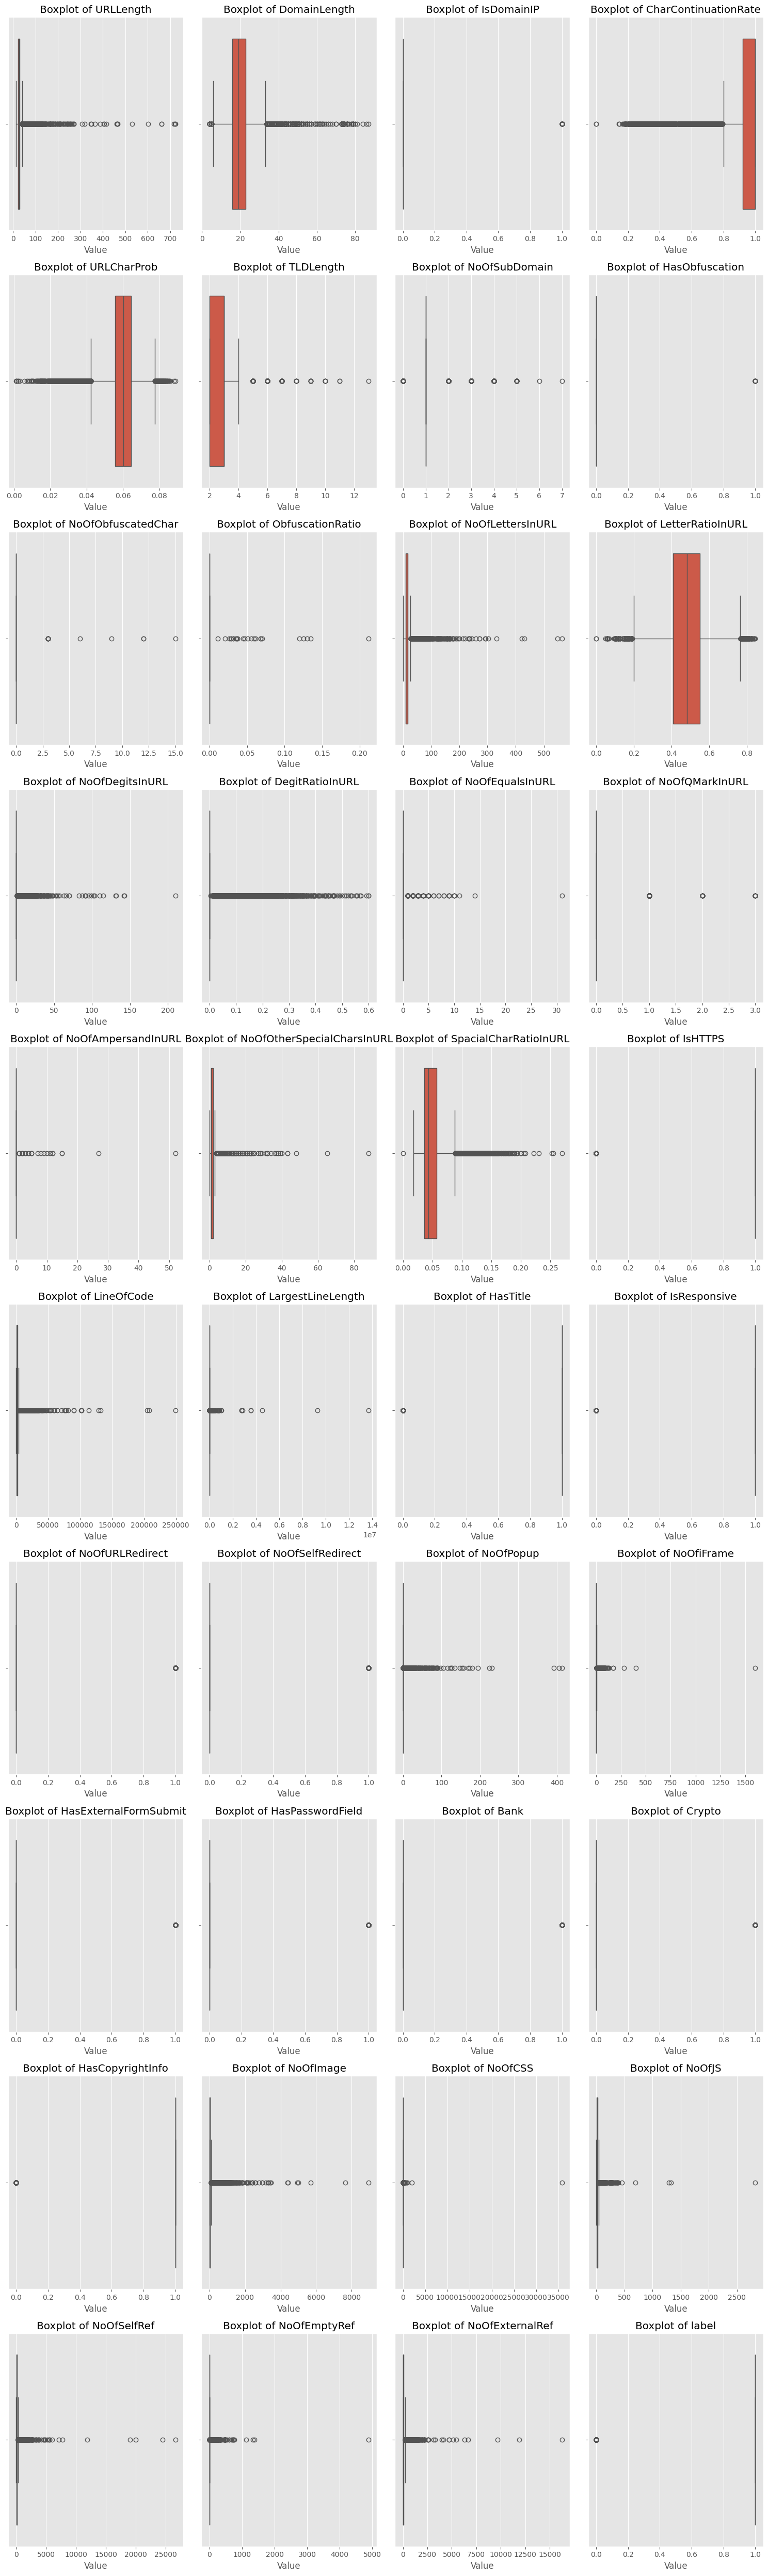

In [ ]:
num_cols = 4
num_rows = math.ceil(len(list_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(list_columns):
    sns.boxplot(data=train_data, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel('Value')

for j in range(len(list_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### **Insight**:
* Dataset memiliki banyak data yang bernilai **null** dan banyak kolom yang setengahnya berisikan **null** value.
* Boxplot pada dataset menggambarkan bahwa memiliki **banyak sekali outliers** dan distribusi yang digambarkan **tidak berbentuk distribusi normal** yang mengakibatkan banyak outliers yang terdeteksi

## Correlation

### Correlation with 'label'

In [ ]:
df_no_id = train_data.drop(columns=['id'], errors='ignore')
corr_matrix = df_no_id.corr(numeric_only=True)

label_corr = corr_matrix['label'].sort_values(ascending=False)

fig = go.Figure(go.Bar(
    x=label_corr.index,
    y=label_corr.values,
    marker=dict(color=label_corr.values, colorscale='Viridis', showscale=True),
))

fig.update_layout(
    title='Correlation of Features with "label"',
    xaxis_title='Features',
    yaxis_title='Correlation with "label"',
    xaxis_tickangle=-45,
)

# Show the plot
fig.show()

#### **Insight :**
* `IsHTTPS` dan `DegitRationInURL` memiliki korelasi tertinggi dengan label
* `IsHTTPS` tinggi menandakan bahwa kebanyakan website phising sudah menggunakan protokol HTTPS
* Kemudian, dilanjutkan dengan `HasTitle` dan `SpacialCharRationInURL` memiliki korelasi tertinggi kedua dengan label
* Pada data, `NoOfPopUp` dan `NoOfSubDomain` memiliki korelasi paling rendah dengan label dan dapat dibuang pada saat pemrosesan data

## Numerical Features Distribution

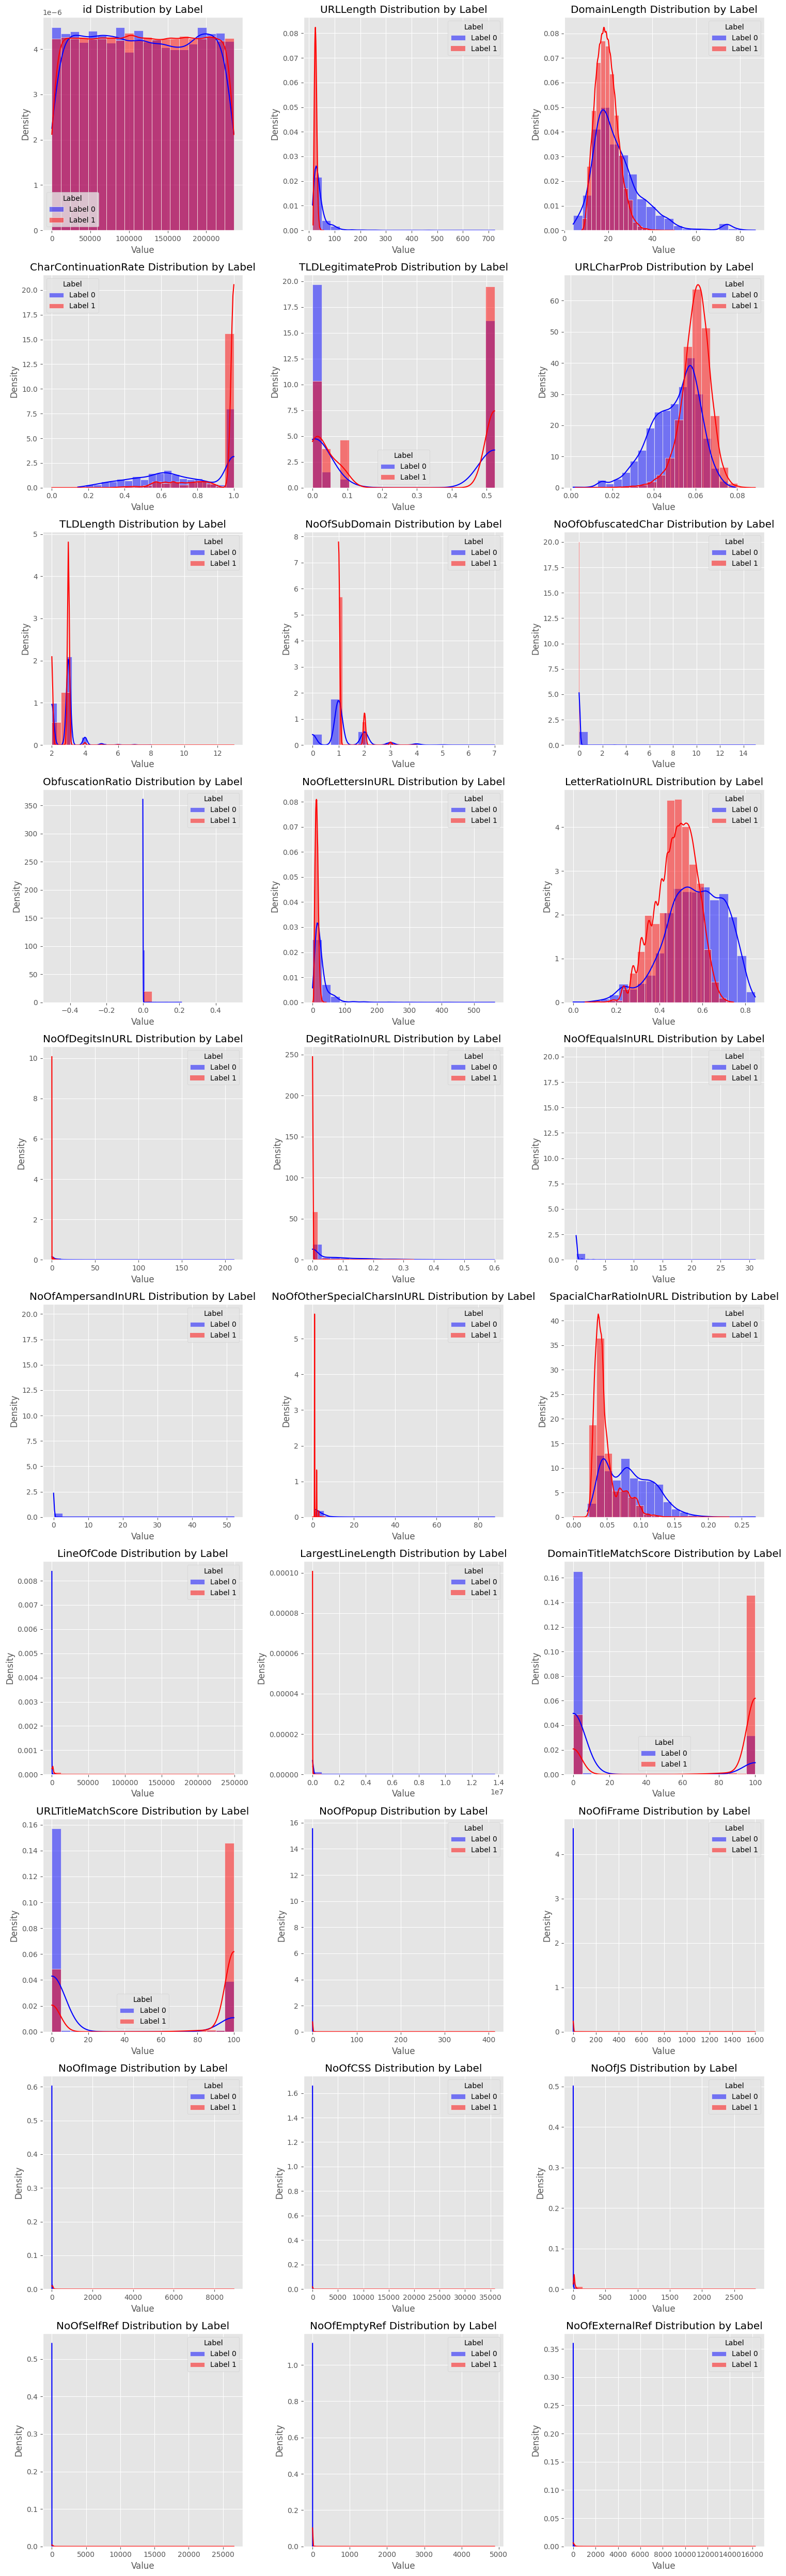

In [ ]:
cont_cols = [f for f in train_data.columns if train_data[f].dtype in [float, int] and train_data[f].nunique() > 5]

num_cols = 3
num_rows = math.ceil(len(cont_cols) / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axs = axs.flatten()

for i, col in enumerate(cont_cols):
    data_label_0 = train_data[train_data['label'] == 0][col]
    data_label_1 = train_data[train_data['label'] == 1][col]

    sns.histplot(data_label_0, color='blue', kde=True, bins=20, label='Label 0', ax=axs[i], stat='density')
    sns.histplot(data_label_1, color='red', kde=True, bins=20, label='Label 1', ax=axs[i], stat='density')

    axs[i].set_title(f'{col} Distribution by Label')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')
    axs[i].legend(title='Label')

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()

# Display the plot
plt.show()

#### **Insight :**
* Data numeric pada setiap kolom sebagian besar memiliki distribusi yang sangat tidak teratur akibat banyak outliers pada data - data tersebut disertai juga dengan banyak nilai null pada data

## Categorical Features Distribution

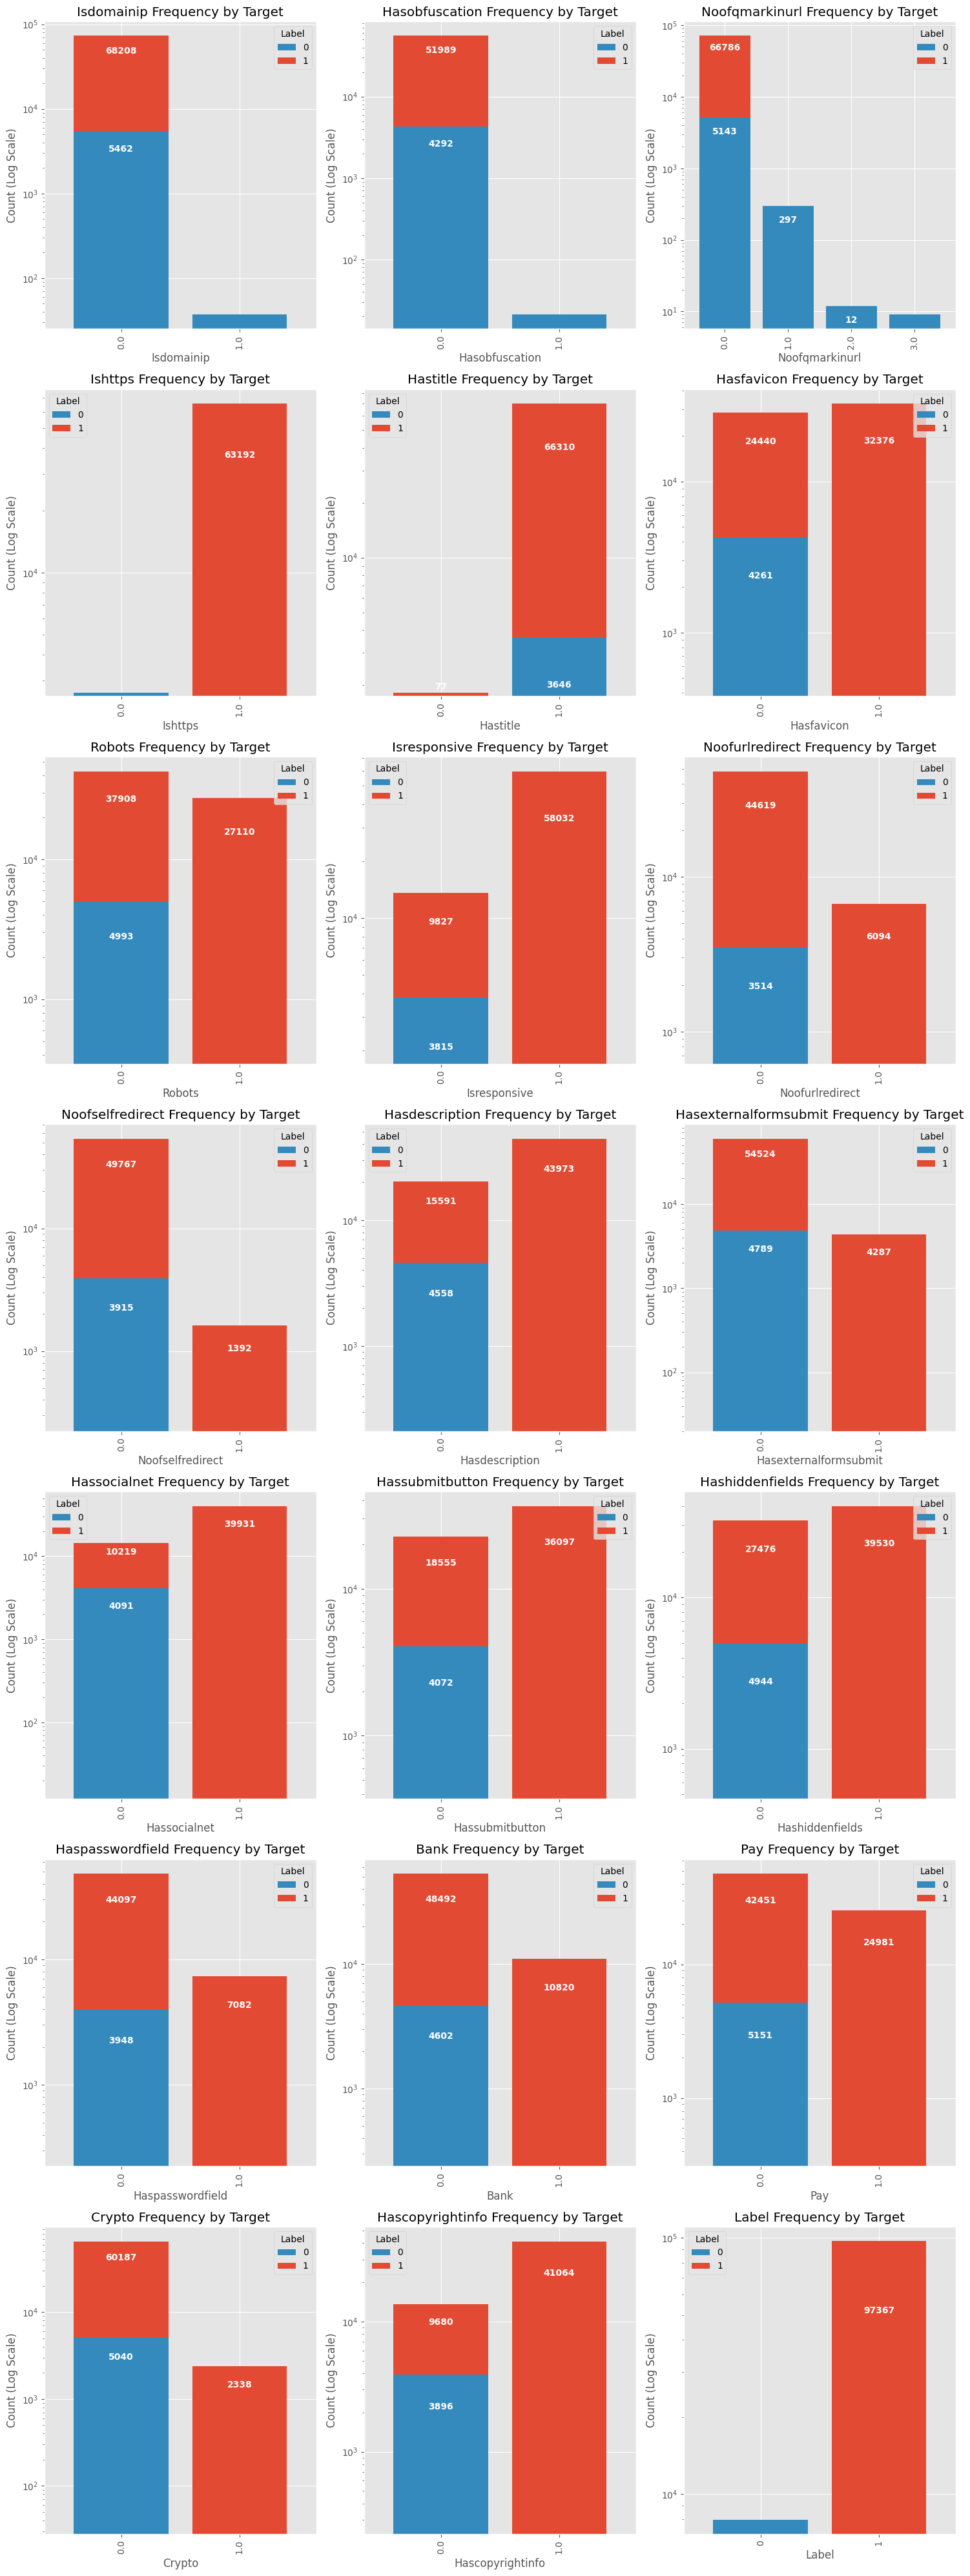

In [ ]:
cat_features = []
for column in train_data.columns :
    unique_threshold  = 5
    if train_data[column].nunique() < unique_threshold:
      cat_features.append(column)

num_cols = 3
num_rows = math.ceil(len(cat_features) / num_cols)

target = 'label'

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 40))

axs = axs.flatten()

for i, col in enumerate(cat_features):
    freq_table = pd.crosstab(train_data[col], train_data[target])

    freq_table.plot(kind='bar', stacked=True, ax=axs[i], color=['#348ABD', '#E24A33'], width=0.8)

    axs[i].set_yscale('log')

    for p in axs[i].patches:
        height = p.get_height()
        y_position = p.get_y() + height / 2
        axs[i].annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., y_position),
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold',
                        xytext=(0, 8), textcoords='offset points')

    axs[i].set_title(f"{col.title()} Frequency by Target")
    axs[i].set_xlabel(col.title())
    axs[i].set_ylabel("Count (Log Scale)")
    axs[i].legend(title="Label", labels=['0', '1'])



for j in range(i + 1, len(axs)):
    axs[j].axis('off')

fig.tight_layout()

plt.show()

#### **Insight :**
* Berdasarkan grafik distribusi yang dibuat, dapat diperhatikan bahwa label 0 dan 1 tidak terbagi dengan baik pada dataset yang dapat mengakibatkan model akhir lebih cenderung memberi output 1
* Selain itu, pada beberapa bagian lain dapat diperhatikan bahwa banyak sekali data yang tidak imbang, selain pada label, seperti pada ishttps, istitle, dll
* Data yang tidak seimbang pada kasus ini akan menyebabkan permasalahan pada saat melakukan modelling dan lebih baik tidak digunakan sebagai sebuah fitur

## Wordcloud

### Non Phising Website

In [ ]:
columns_to_plot = train_data.select_dtypes(include=['object']).columns.tolist()

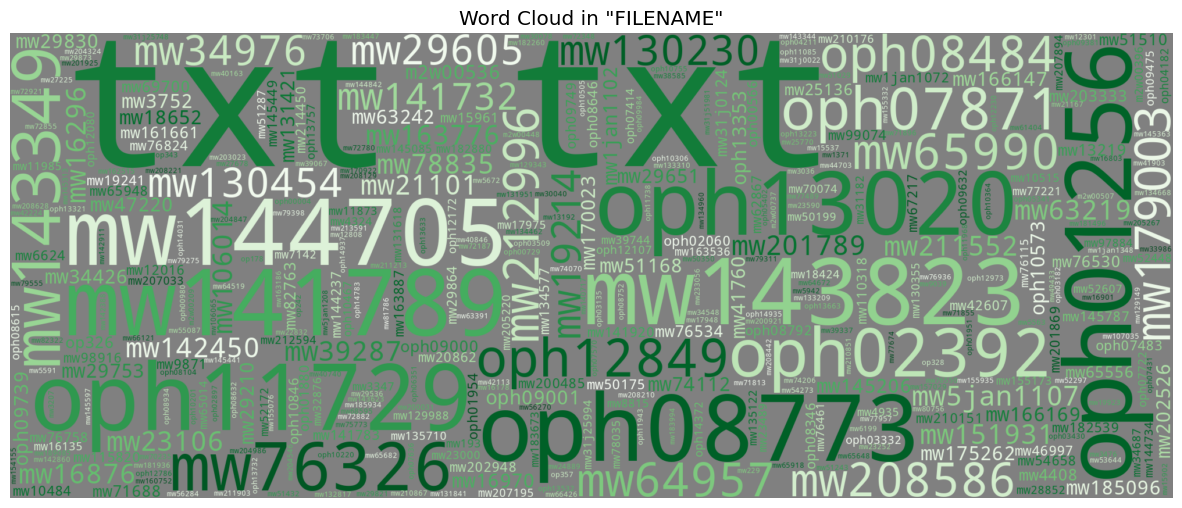

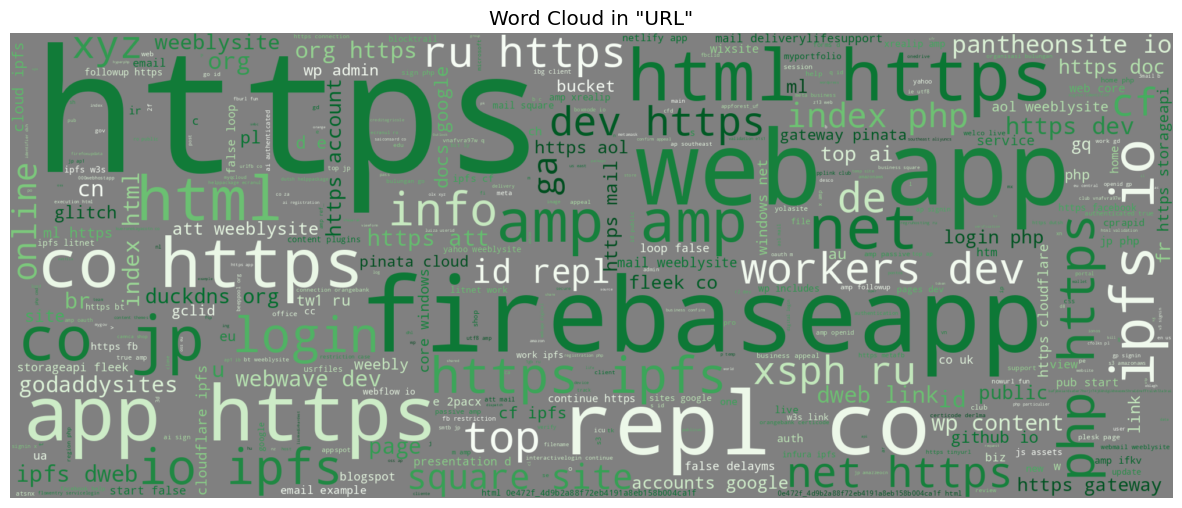

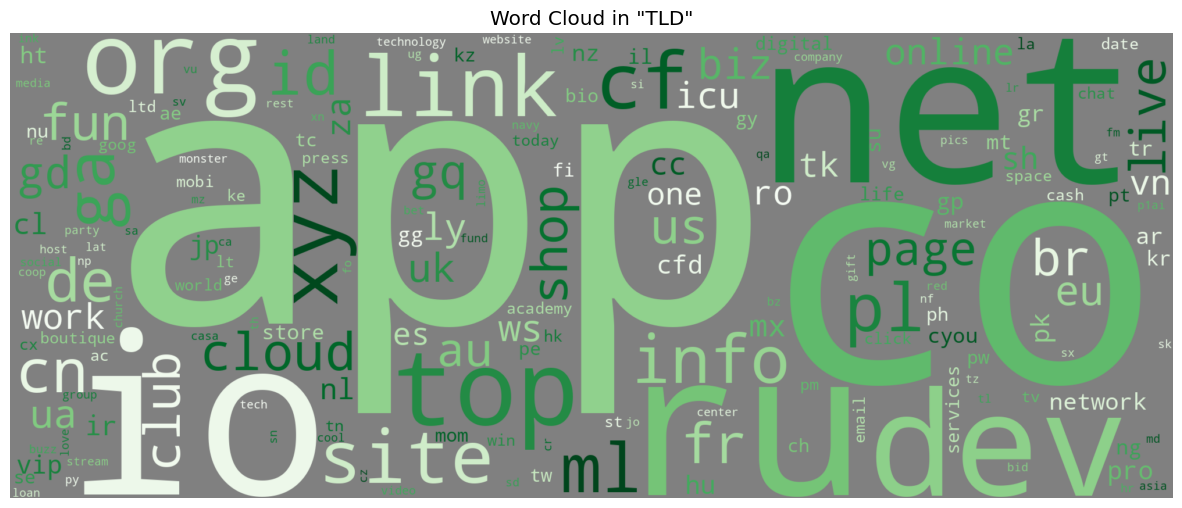

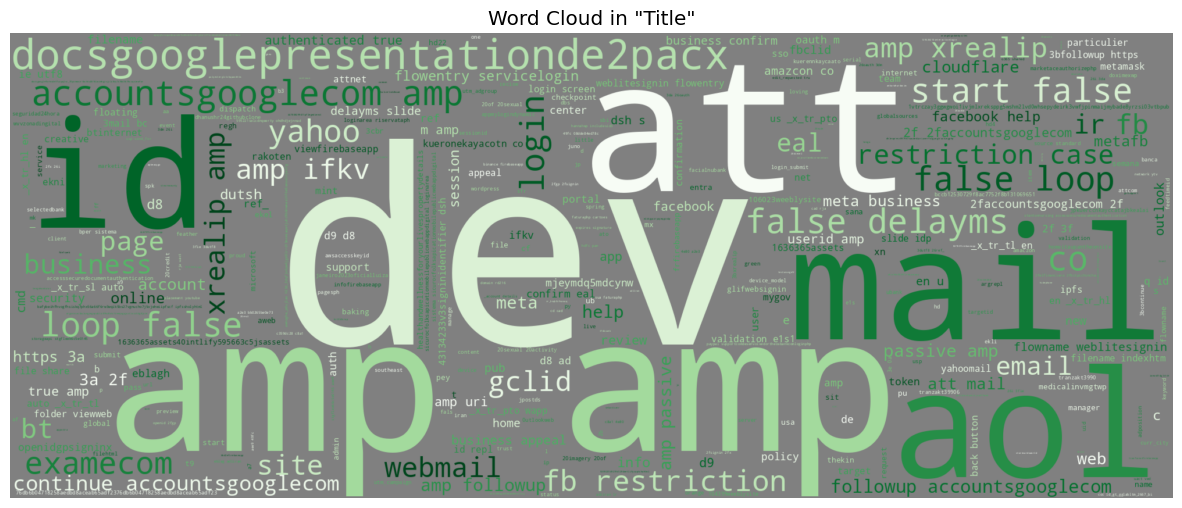

In [ ]:
for column in columns_to_plot:

    positive_text = ' '.join(train_data[train_data['label'] == 0][column].dropna().astype(str))

    wordcloud = WordCloud(
        background_color='gray',
        width=2000,
        height=800,
        max_words=400,
        colormap='Greens'
    ).generate(positive_text)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud in "{column}"')
    plt.show()

### Phising Website

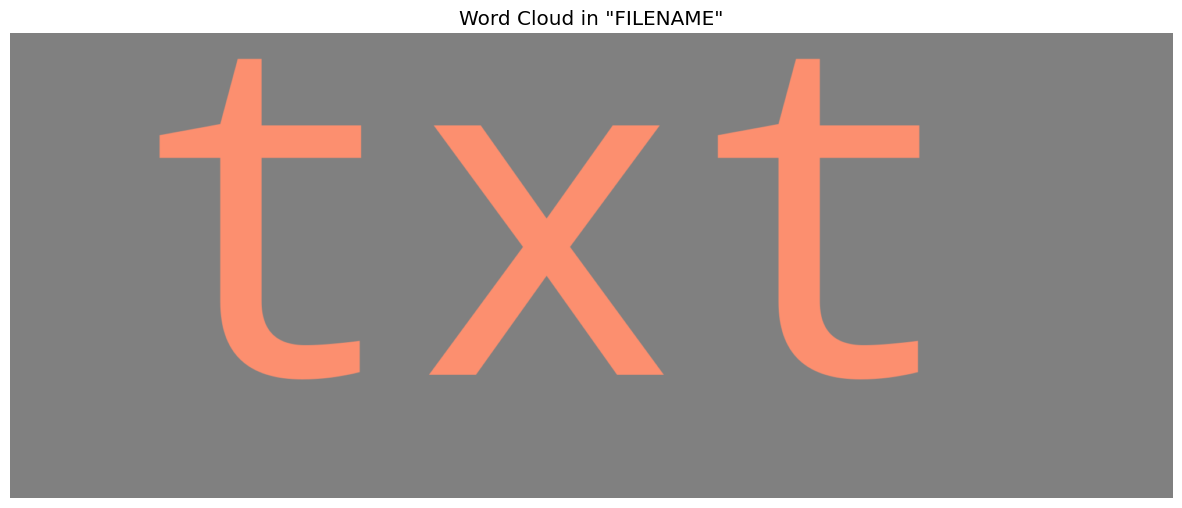

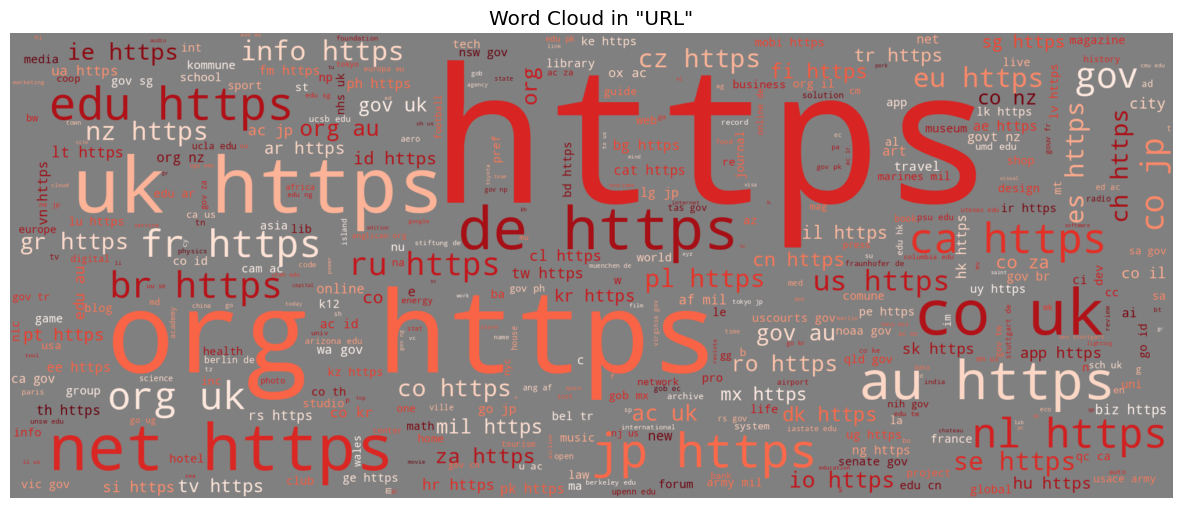

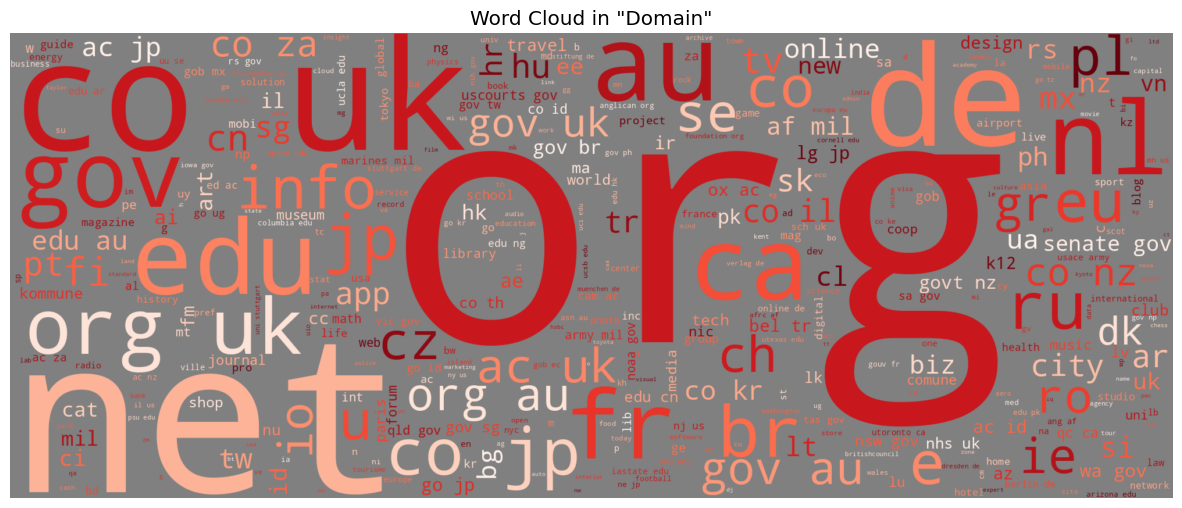

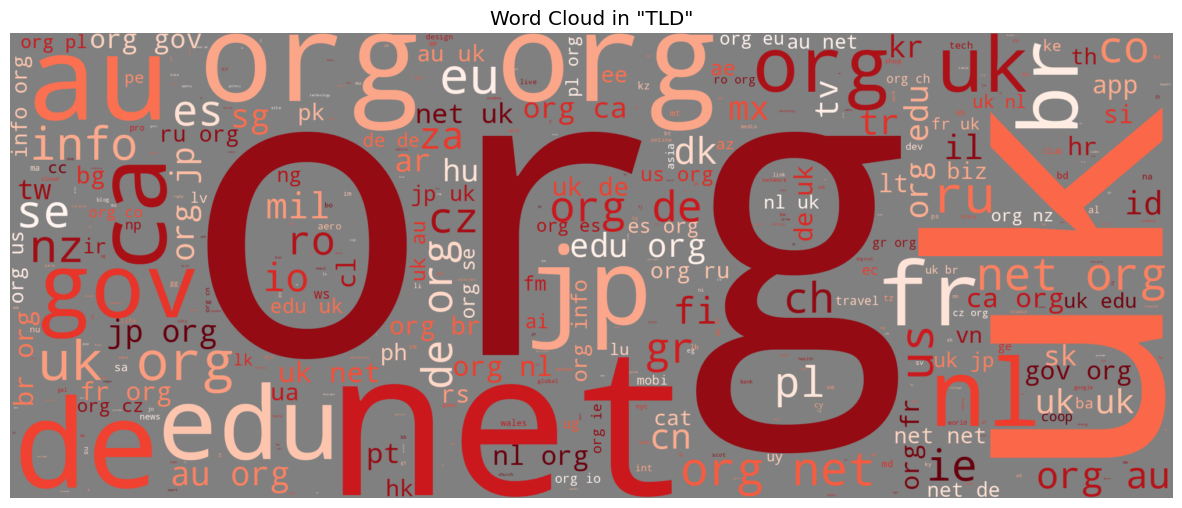

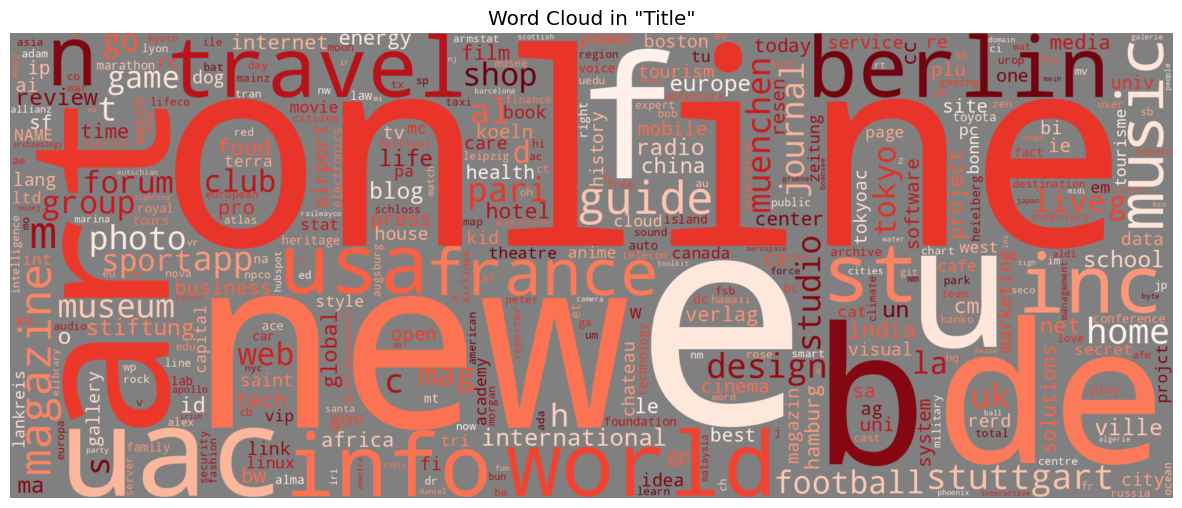

In [ ]:
for column in columns_to_plot:

    positive_text = ' '.join(train_data[train_data['label'] == 1][column].dropna().astype(str))

    wordcloud = WordCloud(
        background_color='gray',
        width=2000,
        height=800,
        max_words=400,
        colormap='Reds'
    ).generate(positive_text)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud in "{column}"')
    plt.show()

####  **Insight :**
* Website yang digunakan banyak menggunakan protokol https disebabkan karena pada dataset hampir semua website yang digunakan merupakan https
* Website dengan judul / title 'online' atau 'new' sebagian besar merupakan website phising dilengkapi dengan '.org' ataupun '.uk'
* Pada dataset website yang digunakan banyak berasal dari UK melihat domain yang digunakan memiliki akhiran '.uk'
* Pada dataset banyak digunakan website ataupun aplikasi firebase, tetapi tidak terdapat indikasi sebagai website phising yang dimungkinkan karena ketentuan dari google yang ketat pada penggunaan firebase

# Data Cleaning

## Revocering Missing Data

### Recovering Data Manually

#### **Domain**
As we can see there are some row that have `URL` but missing `Domain`. So based on this facts, we can try to recovering the `Domain` from `URL`  

In [7]:
 def recover_domain(row):
    if pd.isna(row['Domain']) and not pd.isna(row['URL']):
        return urlparse(row['URL']).netloc
    else :
        return row['Domain']

#### **Domain Length**

In [8]:
def recover_domain_length(row):
  if(not pd.isna(row['Domain']) ):
      return len(row['Domain'])
  return row['DomainLength']

#### **HTTPS**

In [9]:
def recover_ishttps(row):
    if pd.isna(row['IsHTTPS']) and not pd.isna(row['URL']):
        parsed_url = urlparse(row['URL'])
        return parsed_url.scheme == "https"
    else:
        return row['IsHTTPS']

#### **URL**

In [10]:
def recover_url(row):
    if not pd.isna(row['URL']):
        return row['URL']
    if not pd.isna(row['Domain']) or pd.isna(row['TLD']):
        return None
    protocol = "https://" if row['IsHTTPS'] == 1 else "http://"
    return f"{protocol}{row['Domain']}.{row['TLD']}"

#### **Title**

In [11]:
# import requests
# from bs4 import BeautifulSoup

# def get_website_title(url):
#     try:
#         # Fetch the webpage
#         response = requests.get(url, timeout=2)
#         response.raise_for_status()  # Raise an error for bad HTTP responses (e.g., 404, 500)

#         # Parse the HTML
#         soup = BeautifulSoup(response.text, 'html.parser')

#         # Extract the title
#         title = soup.title.string.strip() if soup.title and soup.title.string else pd.NA
#         return title
#     except requests.exceptions.RequestException as e:
#         return pd.NA

# def recover_title(row):
#     if(pd.isna(row['Title'])):
#         if(not pd.isna(row['URL'])) :
#             temp = get_website_title(row['URL'])
#             return temp
#         else :
#             return row['Title']
#     else :
#         return row['Title']

In [12]:
# train_data['Title'] = train_data.apply(recover_title, axis = 1)

In [13]:
# train_data['Title'].isnull().sum()

In [14]:
# train_data

#### **HasTitle**

In [15]:
def recover_hasTitle(row):
    if pd.isna(['HasTitle']) and not pd.isna(['Title']):
        return 1
    else : return row['HasTitle']

#### **SpacialCharRatioInURL**

In [16]:
import unicodedata
import re

def special_char_ratio(domain):
    # Regex to match letters, numbers, and common whitespace
    alphanumeric_pattern = re.compile(r"[a-zA-Z0-9\s.]")

    # Count the number of non-alphanumeric (special) characters
    special_count = sum(1 for char in domain if not alphanumeric_pattern.match(char))

    # Calculate the ratio
    ratio = special_count / len(domain) if len(domain) > 0 else 0
    return np.float64(ratio)

def recover_specialCharRatio(row):
    if pd.isna(row['SpacialCharRatioInURL'] and not pd.isna(row['Domain'])):
        return special_char_ratio(row['Domain'])
    else :
        return np.float64(row['SpacialCharRatioInURL'])

#### **DegitRatioInURL**

In [17]:
import re
import pandas as pd
import numpy as np

def count_degit_ratio(url):
    # Find all sequences of digits
    if pd.isna(url):
        return np.nan
    numbers = re.findall(r'\d+', url)

    # Calculate the digit ratio
    if len(url) > 0:
        ratio = sum(len(num) for num in numbers) / len(url)
    else:
        ratio = 0
    return np.float64(ratio)

def recover_degit_ratio(row):
    if pd.isna(row['DegitRatioInURL']):
        if pd.notna(row['Domain']):
            # Calculate digit ratio for 'Domain'
            return count_degit_ratio(row['Domain'])
        else:
            # Return NaN if both DegitRatioInURL and Domain are NaN
            return np.nan
    else:
        return np.float64(row['DegitRatioInURL'])


## **Imputation**

## Preparing Pipeline

In [18]:
class FeatureRecovery(BaseEstimator, TransformerMixin):

    def __init__(self, column_func):
        self.column_func = column_func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        for column, func in self.column_func:
            print(f"Applying function {func.__name__} to column: {column}")  # Debug print
            X_copy[column] = X_copy.apply(func, axis=1)
        return X_copy

# Data Preprocessing

## Randomize Simple Imputer

In [34]:
import random
class RandomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_imputer = SimpleImputer(strategy='median')
        self.freq_imputer = SimpleImputer(strategy='most_frequent')

    def fit(self, X, y=None):
        # Fit both imputers
        self.mean_imputer.fit(X)
        self.freq_imputer.fit(X)
        return self

    def transform(self, X):
        # Randomly choose the imputer
        choice = random.choice(['median', 'most_frequent'])
        if choice == 'median':
            return self.mean_imputer.transform(X)
        else:
            return self.freq_imputer.transform(X)

# Compile and Run the Pipeline

In [161]:
columns_categorical = ['HasTitle', 'HasSocialNet', 'IsHTTPS','HasCopyrightInfo', 'HasDescription', 'IsResponsive']
columns_numerical = ['DegitRatioInURL', 'DomainLength','SpacialCharRatioInURL','DomainTitleMatchScore', 'CharContinuationRate', 'NoOfOtherSpecialCharsInURL']

feature_recovery = FeatureRecovery(
    column_func = [('Domain',recover_domain), ('DomainLength', recover_domain_length),
     ('IsHTTPS',recover_ishttps), ('URL',recover_url),('DegitRatioInURL',recover_degit_ratio),
      ('SpacialCharRatioInURL',recover_specialCharRatio)]
)

custom_imputer_num = RandomizedSimpleImputer(strategy='median')
custom_imputer_cat = RandomizedSimpleImputer(strategy='most_frequent')

column_transformer = ColumnTransformer(
    transformers=[
        ('random_imputer', RandomImputer(),columns_categorical ),
        ('default_imputer', SimpleImputer(strategy='mean'), columns_numerical)
    ],
     remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('feature_recovery', feature_recovery),
    ('transformer',column_transformer )
])

## Pipeline for Training

Dropping Label Columns to make it usable for test

In [76]:
train_no_label = train_data.drop('label', axis=1)

In [77]:
pipeline.fit(train_no_label)

Applying function recover_domain to column: Domain
Applying function recover_domain_length to column: DomainLength
Applying function recover_ishttps to column: IsHTTPS
Applying function recover_url to column: URL
Applying function recover_degit_ratio to column: DegitRatioInURL
Applying function recover_specialCharRatio to column: SpacialCharRatioInURL


/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('feature_recovery',
                 FeatureRecovery(column_func=[('Domain',
                                               <function recover_domain at 0x79b2528d67a0>),
                                              ('DomainLength',
                                               <function recover_domain_length at 0x79b29cdff520>),
                                              ('IsHTTPS',
                                               <function recover_ishttps at 0x79b2529ab250>),
                                              ('URL',
                                               <function recover_url at 0x79b2989b5630>),
                                              ('DegitRatioInURL',
                                               <function recover_degit_ratio at 0x79b2989b5c60>),
                                              ('...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('random_imputer',
                                                  RandomImputer(),
                                                  ['HasTitle', 'HasSocialNet',
                                                   'IsHTTPS',
                                                   'HasCopyrightInfo',
                                                   'HasDescription',
                                                   'IsResponsive']),
                                                 ('default_imputer',
                                                  SimpleImputer(),
                                                  ['DegitRatioInURL',
                                                   'DomainLength',
                                                   'SpacialCharRatioInURL',
                                                   'DomainTitleMatchScore',
                                                   'CharContinuationRate',
                                                   'NoOfOtherSpecialCharsInURL'])]))])

In [83]:
 processed_data = pipeline.transform(train_no_label)

Applying function recover_domain to column: Domain
Applying function recover_domain_length to column: DomainLength
Applying function recover_ishttps to column: IsHTTPS
Applying function recover_url to column: URL
Applying function recover_degit_ratio to column: DegitRatioInURL
Applying function recover_specialCharRatio to column: SpacialCharRatioInURL


In [84]:
used_feature = columns_categorical + columns_numerical

In [85]:
all_columns = columns_categorical + columns_numerical

categorical_imputed_columns = columns_categorical
numerical_imputed_columns = columns_numerical


remaining_columns = [col for col in train_data.columns if col not in all_columns]
remaining_columns.remove('label')


final_columns = categorical_imputed_columns + numerical_imputed_columns + remaining_columns
processed_df = pd.DataFrame(processed_data, columns=final_columns)

In [86]:
processed_df[used_feature].isnull().sum()

HasTitle                      0
HasSocialNet                  0
IsHTTPS                       0
HasCopyrightInfo              0
HasDescription                0
IsResponsive                  0
DegitRatioInURL               0
DomainLength                  0
SpacialCharRatioInURL         0
DomainTitleMatchScore         0
CharContinuationRate          0
NoOfOtherSpecialCharsInURL    0
dtype: int64

## Pipeline for Validation

In [87]:
val_no_label = val_data.drop('label', axis=1)

In [88]:
val_processed_data = pipeline.transform(val_no_label)

Applying function recover_domain to column: Domain
Applying function recover_domain_length to column: DomainLength
Applying function recover_ishttps to column: IsHTTPS
Applying function recover_url to column: URL
Applying function recover_degit_ratio to column: DegitRatioInURL
Applying function recover_specialCharRatio to column: SpacialCharRatioInURL


In [89]:
val_processed_df = pd.DataFrame(val_processed_data, columns=final_columns)

In [90]:
val_processed_df[used_feature].isnull().sum()

HasTitle                      0
HasSocialNet                  0
IsHTTPS                       0
HasCopyrightInfo              0
HasDescription                0
IsResponsive                  0
DegitRatioInURL               0
DomainLength                  0
SpacialCharRatioInURL         0
DomainTitleMatchScore         0
CharContinuationRate          0
NoOfOtherSpecialCharsInURL    0
dtype: int64

## Pipeline for Test

In [91]:
test_processed_data = pipeline.transform(test_df)

Applying function recover_domain to column: Domain
Applying function recover_domain_length to column: DomainLength
Applying function recover_ishttps to column: IsHTTPS
Applying function recover_url to column: URL
Applying function recover_degit_ratio to column: DegitRatioInURL
Applying function recover_specialCharRatio to column: SpacialCharRatioInURL


In [92]:
test_processed_data = pd.DataFrame(test_processed_data, columns=final_columns)

## Re-Sampling Validation

In [93]:
val_processed_df['label']= val_data['label'].values

In [94]:
from sklearn.utils import resample
import pandas as pd

majority_class = val_processed_df[val_processed_df['label'] == val_processed_df['label'].value_counts().idxmax()]
classes = val_processed_df['label'].unique()

resampled_dfs = [majority_class]
for cls in classes:
    if cls != majority_class['label'].iloc[0]:
        minority_class = val_processed_df[val_processed_df['label'] == cls]
        resampled_dfs.append(resample(minority_class,
                                      replace=True,
                                      n_samples=len(majority_class),
                                      random_state=42))

upscaled_val_df = pd.concat(resampled_dfs)

## Re-Sampling Training

In [95]:
processed_df['label']= train_data['label'].values

In [96]:
from sklearn.utils import resample
import pandas as pd

# Assume df is your dataset, with 'label' as the class column
majority_class = processed_df[processed_df['label'] == processed_df['label'].value_counts().idxmax()]
classes = processed_df['label'].unique()

# Resample minority classes
resampled_dfs = [majority_class]
for cls in classes:
    if cls != majority_class['label'].iloc[0]:
        minority_class = processed_df[processed_df['label'] == cls]
        resampled_dfs.append(resample(minority_class,
                                      replace=True,
                                      n_samples=len(majority_class),
                                      random_state=42))

upscaled_train_df = pd.concat(resampled_dfs)

# Modelling

## KNN

### Model From Scratch

In [118]:
class KNN:
    """
    K-Nearest Neighbors (KNN) classification algorithm

    Parameters:
    -----------
    n_neighbors : int, optional (default=5)
        Number of neighbors to use in the majority vote.

    Methods:
    --------
    fit(X_train, y_train):
        Stores the values of X_train and y_train.

    predict(X):
        Predicts the class labels for each example in X.

    """
    def __init__(self, k=3, algorithm = "Euclidean", r = 1):
        self.k = k
        self.algorithm = algorithm
        self.r = r

    def fit(self, X, y):
        """
        Only stores the values of X_train and y_train.

        Parameters:
        -----------
        X_train : numpy.ndarray, shape (n_samples, n_features)
            The training dataset.

        y_train : numpy.ndarray, shape (n_samples,)
            The target labels.
        """
        self.X_train = X
        self.y_train = y.astype(int)

    def euclidean_distance(self, x1, x2):
        """
        Calculate the Euclidean distance between two data points.

        Parameters:
        -----------
        x1 : numpy.ndarray, shape (n_features,)
            A data point in the dataset.

        x2 : numpy.ndarray, shape (n_features,)
            A data point in the dataset.

        Returns:
        --------
        distance : float
            The Euclidean distance between x1 and x2.
        """
        return np.linalg.norm(x1-x2, axis=1)

    def manhattan_distance(self, x1, x2):
        """
        Calculate the Manhattan distance between two data points.

        Parameters:
        -----------
        x1 : numpy.ndarray, shape (n_features,)
            A data point in the dataset.

        x2 : numpy.ndarray, shape (n_features,)
            A data point in the dataset.

        Returns:
        --------
        distance : float
            The Manhattan distance between x1 and x2.
        """
        return np.linalg.norm(x1-x2, ord=1, axis=1)

    def minowski_distance(self, x1, x2, r):
        """
        Calculate the Minowski distance between two data points.

        Parameters:
        -----------
        x1 : numpy.ndarray, shape (n_features,)
            A data point in the dataset.

        x2 : numpy.ndarray, shape (n_features,)
            A data point in the dataset.

        Returns:
        --------
        distance : float
            The Minowski distance between x1 and x2.
        """
        return np.power(np.sum(np.abs(x1 - x2) ** r), 1 / r)

    def _predict(self, x):
        """
        Predicts the class label for a single row of data only.

        Parameters:
        -----------
        x : numpy.ndarray, shape (n_features,)
            A data point in the test dataset.

        Returns:
        --------
        most_closest_label : int
            The predicted class label for x.
        """

        if(self.algorithm.lower() == "minowski"):
            distances = self.minowski_distance(self.X_train, x, r)
        elif(self.algorithm.lower() == "euclidean"):
            distances = self.euclidean_distance(self.X_train, x)
        else :
            distances = self.manhattan_distance(self.X_train, x)

        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        most_closest_label = np.bincount(k_nearest_labels).argmax()
        return most_closest_label

    def save_model(self, filename):
        """
        Saves the trained KNN model to a file.

        Parameters:
        -----------
        filename : str
            The name of the file to save the model.
        """
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f"Model saved to {filename}")

    @staticmethod
    def load_model(filename):
        """
        Loads a trained KNN model from a file.

        Parameters:
        -----------
        filename : str
            The name of the file from which to load the model.

        Returns:
        --------
        model : KNN
            The loaded KNN model.
        """
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Model loaded from {filename}")

    def predict(self, X):
        """
        Using Parralel predicts the class labels for each example in X.

        Parameters:
        -----------
        X : numpy.ndarray, shape (n_samples, n_features)
            The test dataset.

        Returns:
        --------
        predictions : numpy.ndarray, shape (n_samples,)
            The predicted class labels for each example in X.
        """
        return np.array(Parallel(n_jobs=-1)(delayed(self._predict)(x) for x in X))  # Use all CPU cores


In [119]:
def compute_accuracy(y_true, y_pred):
    """
    Computes the accuracy of a classification model.

    Parameters:
    y_true (numpy array): A numpy array of true labels for each data point.
    y_pred (numpy array): A numpy array of predicted labels for each data point.

    Returns:
    float: The accuracy of the model, expressed as a percentage.
    """
    y_true = y_true.flatten()
    total_samples = len(y_true)
    correct_predictions = np.sum(y_true == y_pred)
    return (correct_predictions / total_samples)

In [129]:
# X_train = upscaled_train_df[used_feature].astype('float64').to_numpy()
# y_train = upscaled_train_df['label'].astype('float64').to_numpy()

X_train_sampled = upscaled_train_df.sample(frac=0.1, random_state=42)[used_feature].astype('float64').to_numpy()
y_train_sampled = upscaled_train_df.sample(frac=0.1, random_state=42)['label'].astype('float64').to_numpy()


In [130]:
model = KNN(2)
model.fit(X_train, y_train)

In [131]:
# X_test = upscaled_val_df[used_feature].astype('float64').to_numpy()
# y_test = upscaled_val_df['label'].astype('float64').to_numpy()

X_test_sampled = upscaled_val_df.sample(frac=0.1, random_state=42)[used_feature].astype('float64').to_numpy()
y_test_sampled = upscaled_val_df.sample(frac=0.1, random_state=42)['label'].astype('float64').to_numpy()


In [132]:
predictions = model.predict(X_test_sampled)

In [133]:
predictions

array([0, 1, 1, ..., 1, 0, 1])

In [152]:
accuracy = compute_accuracy(y_test_sampled, predictions)
print(f" our model got accuracy score of : {accuracy}")

 our model got accuracy score of : 0.915293392884645


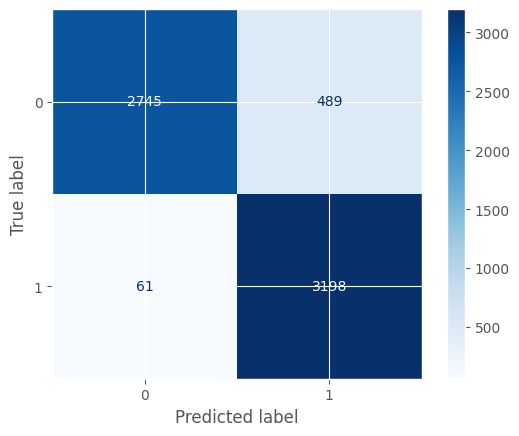

In [139]:
conf_matrix(y_test_sampled, predictions)

In [164]:
# y_test_pred = model.predict(test_processed_data[used_feature].astype('float64').to_numpy())
# sub = pd.DataFrame({'id':test_processed_data['id'],'label':y_test_pred})
# sub.to_csv('submission_knn.csv',index=False)

### Model From sklearn

In [140]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=2)
X_train_knn = upscaled_train_df[used_feature].astype('float64')
y_train_knn = upscaled_train_df['label'].astype('float64')
X_test_knn = upscaled_val_df[used_feature].astype('float64')
y_test_knn = upscaled_val_df['label'].astype('float64')

knn.fit(X_train_knn, y_train_knn)

y_pred = knn.predict(X_test_knn)
print(f'Accuracy: {accuracy_score(y_test_knn, y_pred)}')

Accuracy: 0.9155808150817855


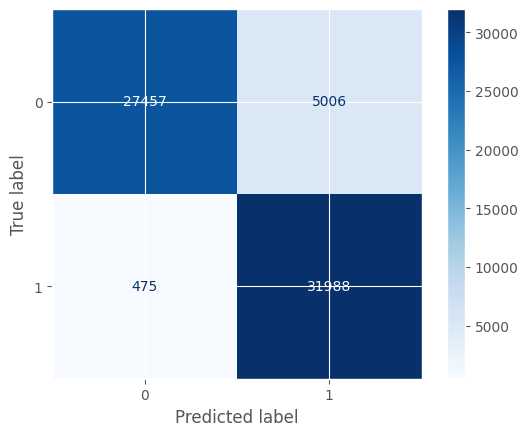

In [141]:
conf_matrix(y_test_knn, y_pred)

### Submition Using KNN

In [64]:
y_test_pred = knn.predict(test_processed_data[used_feature])

In [65]:
len(test_processed_data)

10000

In [66]:
len(test_df)

10000

In [67]:
sub = pd.DataFrame({'id':test_processed_data['id'],'label':y_test_pred})

In [69]:
sub.to_csv('submission2.csv',index=False)

## SVM

### Scratch Model

In [157]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classification algorithm.

    Methods:
    --------
    fit(X_train, y_train):
        Prepares data for the model based on X_train and y_train.

    pdf(x, mean, std):
        Calculates the probability density of a feature according to the Gaussian distribution.

    predict(X):
        Predicts the class labels for each example in X.

    save_model(filename):
        Saves the trained Naive Bayes model to a file.

    load_model(filename):
        Loads a trained Naive Bayes model from a file.
    """

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Prepares data for the model based on X_train and y_train.

        Parameters:
        -----------
        X : numpy.ndarray, shape (n_samples, n_features)
            The training dataset.

        y : numpy.ndarray, shape (n_samples,)
            The target labels.
        """
        self.classes, cls_counts = np.unique(y, return_counts=True)
        self.priors = cls_counts / len(y)

        self.X_cls_mean = np.array([X[y == cls].mean(axis=0) for cls in self.classes])
        self.X_stds = np.array([X[y == cls].std(axis=0) for cls in self.classes])

        self.X_stds[self.X_stds == 0] = 1e-6

    def pdf(self, x: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        """
        Calculate the probability density of a feature according to the Gaussian distribution.

        Parameters:
        -----------
        x : numpy.ndarray, shape (n_features,)
            The feature vector.

        mean : numpy.ndarray, shape (n_features,)
            The mean of each feature.

        std : numpy.ndarray, shape (n_features,)
            The standard deviation of each feature.

        Returns:
        --------
        numpy.ndarray, shape (n_features,)
            The probability density for each feature.
        """
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts the class labels for each example in X.

        Parameters:
        -----------
        X : numpy.ndarray, shape (n_samples, n_features)
            The test dataset.

        Returns:
        --------
        numpy.ndarray, shape (n_samples,)
            The predicted class labels for each example in X.
        """
        n_samples, n_features = X.shape
        n_classes = len(self.classes)

        posteriors = np.zeros((n_samples, n_classes))

        for idx, cls in enumerate(self.classes):
            pdfs = np.array([self.pdf(x, self.X_cls_mean[idx], self.X_stds[idx]) for x in X])
            posteriors[:, idx] = np.prod(pdfs, axis=1) * self.priors[idx]

        return self.classes[np.argmax(posteriors, axis=1)]

    def save_model(self, filename: str) -> None:
        """
        Saves the trained Naive Bayes model to a file.

        Parameters:
        -----------
        filename : str
            The name of the file to save the model.
        """
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f"Model saved to {filename}")

    @staticmethod
    def load_model(filename: str) -> 'GaussianNaiveBayes':
        """
        Loads a trained Naive Bayes model from a file.

        Parameters:
        -----------
        filename : str
            The name of the file from which to load the model.

        Returns:
        --------
        GaussianNaiveBayes
            The loaded Naive Bayes model.
        """
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Model loaded from {filename}")
        return model


In [158]:
model_NB_s = GaussianNaiveBayes()
model_NB_s.fit(X_train, y_train)
y_pred_NB_s = model_NB_s.predict(X_test)

In [159]:
accuracy = compute_accuracy(y_test, y_pred_NB_s)
print(f" our model got accuracy score of : {accuracy}")

 our model got accuracy score of : 0.9144564581215537


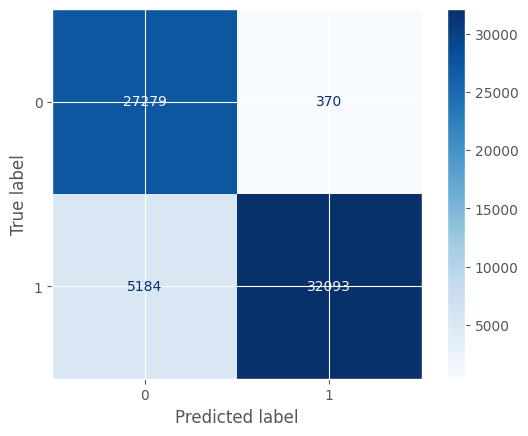

In [160]:
conf_matrix(y_pred_NB_s, y_test)

### Naive Bayes From sklearn

In [162]:
model_NB = GaussianNB()  # Use GaussianNB for continuous data
model_NB.fit(X_train_knn, y_train_knn)  # Train the model
y_pred_NB = model_NB.predict(X_test_knn)
accuracy = compute_accuracy(y_test, y_pred_NB)
print(f" our model got accuracy score of : {accuracy}")

 our model got accuracy score of : 0.9322921479838585


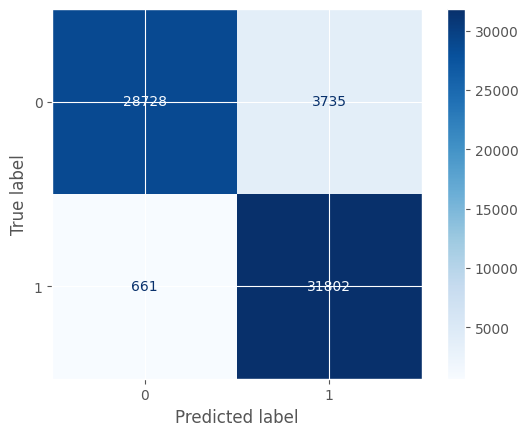

In [144]:
conf_matrix(y_test_knn, y_pred_NB)

In [145]:
y_test_pred = model_NB.predict(test_processed_data[used_feature])

In [146]:
sub = pd.DataFrame({'id':test_processed_data['id'],'label':y_test_pred})

In [147]:
sub.to_csv('submission_NB.csv',index=False)